In [2]:
%pylab inline

import pandas as pd
import pickle
import matplotlib.dates as md
import statsmodels.api as sm
import scipy.stats as dists
import requests

from scipy.misc import factorial
from scipy.optimize import minimize

tableau = pickle.load(open('tableau.colors', 'rb'))

rcParams['figure.figsize'] = (10,8)
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.5
rcParams['axes.prop_cycle'] = cycler('color', tableau)

xfmt = md.DateFormatter('%H:%M:%S')

Populating the interactive namespace from numpy and matplotlib


In [41]:
tenor = '21OCT16'
count = 500 

r = requests.get('https://deribit.com/api/v1/public/getlasttrades?instrument=BTC-%s&count=%d' % (tenor, count)) 
data = r.json()['result'][::-1]

In [42]:
df = pd.DataFrame(columns=['t', 'sd', 'sz', 'px', 'ix'])

df['t']  = list(map(lambda trade: pd.to_datetime(1e6*trade['timeStamp']), data))
df['sd'] = list(map(lambda trade: trade['direction'][0], data))
df['sz'] = list(map(lambda trade: trade['quantity'], data))
df['px'] = list(map(lambda trade: trade['price'], data))
df['ix'] = list(map(lambda trade: trade['indexPrice'], data)) 

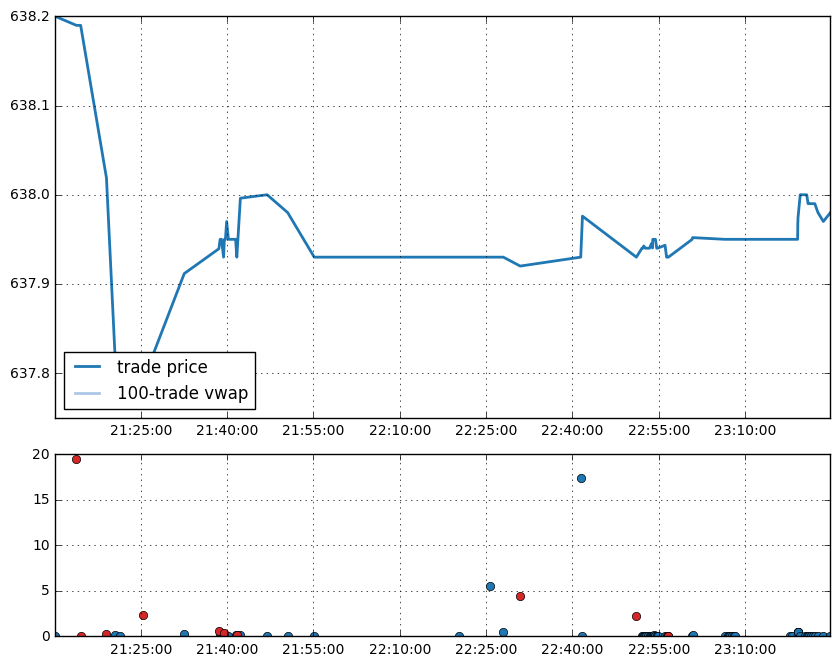

In [5]:
ax = []
ax.append(subplot2grid((3,1),(0,0), rowspan=2))
ax.append(subplot2grid((3,1),(2,0)))

ax[0].plot(df.t, df.px, lw=2, label='trade price')
if data.get('glosten') is not None: 
    ax[0].plot(df.t, df.glosten, lw=2, label='model out')
ax[0].plot(df.t, (df.px * df.sz).rolling(100).sum() / df.sz.rolling(100).sum(), lw=2, label='100-trade vwap')
#ax[1].plot(df.t, (df.sz * (df.sd == 'b')).cumsum(), '-', c=tableau[4])
#ax[1].plot(df.t, (df.sz * (df.sd == 's')).cumsum(), '-', c=tableau[3])
ax[1].plot(df.loc[df.sd == 'b'].t, df.sz.loc[df.sd == 'b'], 'o', c=tableau[0])
ax[1].plot(df.loc[df.sd == 's'].t, df.sz.loc[df.sd == 's'], 'o', c=tableau[6])

ax[0].xaxis.set_major_formatter(xfmt)
ax[0].yaxis.get_major_formatter().set_useOffset(False)
ax[0].legend(loc='lower left')
ax[1].xaxis.set_major_formatter(xfmt)

In [6]:
elapsed = (df.t.iloc[-1] - df.t.iloc[0]).total_seconds() / 3600

print('total trades:        %d' % (len(df)))
print('time elapsed:        %0.1f hours' % elapsed)
print('volume/hour traded:  %0.2f BTC' % (df.sz.sum() / elapsed))
print('dollars/hour traded: %0.2f USD' % ((df.sz*df.px).sum() / elapsed))
print('time between trades: %0.2f seconds' % ((df.t - df.t.shift(1)).mean().total_seconds()))
print('volume per trade:    %0.2f BTC' % (df.sz.mean()))
print('%% trades bought:     %0.1f%%' % (100.*len(df.loc[df.sd == 'b']) / len(df)))
print('%% volume bought:     %0.1f%%' % (100.*(df.sz * (df.sd == 'b')).sum() / df.sz.sum()))
print('stddev/trade:        %0.1f cents' % (100.*(df.px - df.px.shift(1)).std()))

total trades:        77
time elapsed:        2.2 hours
volume/hour traded:  25.66 BTC
dollars/hour traded: 16370.45 USD
time between trades: 106.30 seconds
volume per trade:    0.75 BTC
% trades bought:     84.4%
% volume bought:     47.7%
stddev/trade:        3.6 cents


In [7]:
dt = pd.Timedelta(seconds=30.)
px = pd.Series(list(map(lambda c: df.loc[df.t >= df.t.iloc[0] + c*dt].iloc[0].px, range(0,len(df)))))
px.index = list(map(lambda c: df.t.iloc[0] + c*dt, range(0,len(df))))

In [8]:
model = sm.tsa.AR(px).fit(1)
theta = (1 - model.params['L1.y'])/(dt.total_seconds()/3600)
mu = model.params['const']/(1 - model.params['L1.y'])
sigma = px.std()/sqrt(dt.total_seconds()/3600)
print('(theta, mu, sigma) = (%0.4f, %0.4f, %0.4f)' % (theta, mu, sigma))
print('model pvalue = %0.4f' % model.pvalues['L1.y'])

(theta, mu, sigma) = (9.8897, 637.9242, 1.1911)
model pvalue = 0.0000
